In [2]:
from scipy import stats
from adjustText import adjust_text
import statsmodels.stats.proportion as ssp
import statsmodels.api as sm
import sys
sys.path.append('../figures/scripts/')
import funclib as flib

### A model to predict alpha based on exposure to developmental stages?

Load data

In [3]:
directory = "../data"

# Read DNM data
dnm = pd.read_csv("{}/dnm_est.tsv".format(directory),sep="\t")
dnm["alpha_dnm"] = dnm["Pat DNMs"]/dnm["Mat DNMs"]
dnm["species"] = ["_".join(sp.split()[:2]) for sp in dnm.Species]

# Read traits database
traits = pd.read_csv("{}/zoonomia_assembly_metadata.csv".format(directory))

# Read common names
species2common = pd.read_csv("{}/latin2common_shortened.txt".format(directory),sep="\t").set_index("Species")["Common_names"].to_dict()

# Read substitution rates
subrates = pd.read_csv("{}/subrate_div_data.txt".format(directory),sep="\t")
subrates = subrates[subrates.Subset=="Mammals"]
subrates = subrates[["Species","DivTime","MutPerYearUCSC"]]

# Read alpha from XA
xa_alpha = pd.read_csv("../scripts/alphas/Mammals.Homo_sapiens.LM.tsv",sep="\t")
xa_alpha = xa_alpha[(xa_alpha.mut_type=="mod")].reset_index()

# Merge generation time, subsitution rates and XA alphas
complete_data = xa_alpha.set_index("species").join(subrates.set_index("Species")).join(traits.set_index("Species")).reset_index()

# Generation times
gentimes = pd.read_csv("{}/generation_times.csv".format(directory))
gentimes = gentimes[gentimes.Group=="Mammals"]
Gs = gentimes.set_index("Species")["G"].to_dict()
complete_data["GenerationLength_d"] = [Gs[r.species] for i,r in complete_data.iterrows()]

The model using parameters from evolutionary data

In [4]:
E = 5/3e9

predicted_alphas_l = []

for i,r in complete_data.iterrows():
    
    # Parameters
    p_age, m_age = r.GenerationLength_d, r.GenerationLength_d
    y_rate = r.MutPerYearUCSC/1e6
    gen_rate = p_age*y_rate
    
    # Predict alpha
    pred_alphas = []
    mu_f, mu_m = flib.get_parental_age_effects(gen_rate, m_age, p_age, E, 4)
    pred_alpha = flib.predict_alpha(mu_f, mu_m, m_age, p_age, E)
    
    # With different p-to-m generation time ratio
    average_age = p_age
    pred_alpha_ratios = {}
    for name,ratio in zip(["min", "max"],[0.7, 1.3]):
        m_age, p_age = flib.ratioG(average_age, ratio)
        mu_f, mu_m = flib.get_parental_age_effects_yrate(y_rate, m_age, p_age, E, 4)
        pred_alpha_ratios[name] = flib.predict_alpha(mu_f, mu_m, m_age, p_age, E)
        
    # Keep data for dataframe
    predicted_alphas_l.append([r.species, pred_alpha, pred_alpha_ratios["min"], pred_alpha_ratios["max"]])

# Build dataframe
predicted_alphas = pd.DataFrame(predicted_alphas_l)
predicted_alphas.columns = ["species","predicted_alpha", "predicted_alpha_lwr", "predicted_alpha_upr"]
predicted_alphas["alpha"] = complete_data.alpha
predicted_alphas["max_alpha"] = complete_data.alpha_upr
predicted_alphas["min_alpha"] = complete_data.alpha_lwr

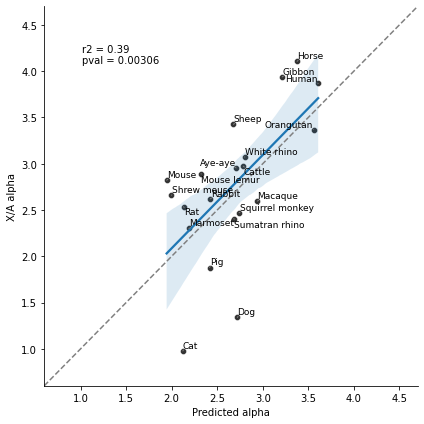

In [5]:
f,ax = plt.subplots(figsize=[6,6])

# Stats
r1,pval = stats.pearsonr(predicted_alphas.predicted_alpha, predicted_alphas.alpha)
r2 = r1**2

# Plot
sns.scatterplot(data=predicted_alphas, x="predicted_alpha",y="alpha",
                ax=ax,legend=False, color="black", alpha=0.8)
sns.regplot(data = predicted_alphas, x="predicted_alpha", y="alpha", 
            ax=ax, scatter=False)

texts = [ax.text(r.predicted_alpha, r.alpha,species2common[r.species], size=9) for i,r in predicted_alphas.iterrows()]
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='gray'))

ax.text(0.1,0.85,"r2 = {:.2f}\npval = {:.5f}".format(r2, pval),transform = ax.transAxes)
flib.identity_line(color="gray")

# Style
ax.set_xlim([0.6,4.7])
ax.set_ylim([0.6,4.7])
ax.set_ylabel("X/A alpha")
ax.set_xlabel("Predicted alpha")
sns.despine()
plt.tight_layout()

#f.savefig("../scripts/pdfs/2exposure_model_no_error_bars.pdf",dpi=1000)

In [34]:
datafor = ['species','alpha','alpha_lwr','alpha_upr','xz_a','xz_a_lwr','xz_a_upr','mut_type','DivTime','MutPerYearUCSC','GenerationLength_d','Order','Genus','SuperOrder','AssemblyAccession','AssemblyName','Organism','AssemblyStatus','Coverage','ContigN50','ScaffoldN50','Sex','Heterozygosity','AnAge_presence','AnAge_ntraits','Female_maturity','Male_maturity','Gestation','Weaning','Litter_size','Litters_per_year','Interbirth_interval','Birth_weight','Weaning_weight','Adult_weight','Growth_rate','Maximum_longevity','Source','Specimen_origin','Sample_size','Data_quality','IMR','MRDT','Metabolic_rate','Body_mass','Temperature','Complex_XY']
tocsv = complete_data[datafor].set_index("species").join(predicted_alphas[["species","predicted_alpha_lwr","predicted_alpha","predicted_alpha_upr"]].set_index("species")).reset_index()
tocsv["common_name"] = [species2common[sp] for sp in tocsv.species]
tocsv.to_csv("./../data/XA_2exposure-model_alphas.csv", sep=",",index=False)

The model using parameters from pedigree data

In [6]:
dnms = pd.read_csv("{}/dnm_est_mutrate.tsv".format(directory),sep="\t")

In [7]:
predicted_alphas_dnms = pd.DataFrame()
for cn,df in dnms.groupby("Common Name"):
    
    # Collapse DNMs from same species
    p = df["Pat DNMs"].sum()
    m = df["Mat DNMs"].sum()
    p_age = np.average(df["Mean Paternal Age at Conception (y)"].values, weights=df["Num Trios"])
    m_age = np.average(df["Mean Maternal Age at Conception (y)"].values, weights=df["Num Trios"])
    alpha = p/m
    sp = "_".join(df["Species"].values[0].split()[:2])
    gen_rate = df["Mutation rate per generation"].mean()
    trios = df["Num Trios"].sum()
    
    if sp=="Ficedula_albicollis":
        c_df = pd.DataFrame([sp, cn, np.mean([p_age,m_age]), p, m, alpha, mu_f, mu_m, np.nan, p+m, trios]).transpose()
        c_df.columns = ["Species", "Common_name", "Age", "Paternal", "Maternal", "dnm_alpha", "maternal_slope", "paternal_slope", "predicted_alpha_dnms", "total_muts", "trios"]
        predicted_alphas_dnms = pd.concat([predicted_alphas_dnms,c_df])
        continue

    # Predict alpha
    mu_f, mu_m = flib.get_parental_age_effects(gen_rate, m_age, p_age, E, 4)
    pred_alpha = flib.predict_alpha(mu_f, mu_m, m_age, p_age, E)
    
    # Build dataframe
    c_df = pd.DataFrame([sp, cn, np.mean([p_age,m_age]), p, m, alpha, mu_f, mu_m, pred_alpha, p+m, trios]).transpose()
    c_df.columns = ["Species", "Common_name", "Age", "Paternal", "Maternal", "dnm_alpha", "maternal_slope", "paternal_slope", "predicted_alpha_dnms", "total_muts", "trios"]
    predicted_alphas_dnms = pd.concat([predicted_alphas_dnms,c_df])

<AxesSubplot:xlabel='predicted_alpha_dnms', ylabel='dnm_alpha'>

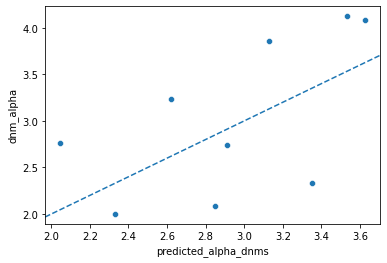

In [8]:
sns.scatterplot(data = predicted_alphas_dnms[(predicted_alphas_dnms.trios>1) & (predicted_alphas_dnms.Species!="Microcebus_murinus")], 
                x="predicted_alpha_dnms", y="dnm_alpha")
flib.identity_line()

In [39]:
predicted_alphas_dnms.to_csv("../data/DNM_2exposure-model_alphas.csv")